## Modelling Time Series: Data Extraction, Processing and Visualization of Independent Variables

In [1]:
# data fetching and manipulation
from fredapi import Fred
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import requests
import pandas_ta
import matplotlib.pyplot as plt

# statistics
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, roc_auc_score, r2_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from fbprophet import Prophet
from hampel import hampel

# ssl issues
import ssl 
try:
    _create_unverified_https_context = ssl._create_unverified_context 
except AttributeError: 
    pass 
else: 
    ssl._create_default_https_context = _create_unverified_https_context

# progress bar
from tqdm.notebook import tqdm_notebook
from IPython.display import clear_output

# Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("deprecated", DeprecationWarning)

## 1) API Fetch

In [2]:
# get api key on fred website and input it as parameter 
fred = Fred(api_key='0c29c6d8d6d8733032c9ff87653f81a6')

# get description of macro-indicators, data frequency and  as string
initial_daily_indic = []
initial_daily_indic_descr = []
x = fred.search('daily').T.loc['title'] # get description of macro-indicators as string
y = fred.search('daily').T.loc['frequency'] # get data frequency as string (d,w,m,q)
z = fred.search('daily').T.columns # get codes of indicators

# create the dataframe with macro-indicators codes and their descriptions (will use a lot later)
for i, e in enumerate(y):
    if e=='Daily':
        initial_daily_indic.append(z[i]) 
        initial_daily_indic_descr.append(x[i])
indic = pd.DataFrame(initial_daily_indic, columns=['indic'])
descr = pd.DataFrame(initial_daily_indic_descr, columns=['descr'])
source = pd.concat([indic, descr], axis=1) # here you specify the number of indicators that you want

## 2) Missing Values

In [3]:
# fetch the macro-indicators data
df = pd.DataFrame()
df_temp = pd.DataFrame(pdr.DataReader(f'AAPL', 'yahoo', '2020-05-06','2022-02-02'))['Adj Close'] 

for index, element in enumerate(tqdm_notebook(source['indic'][:100])): 
    data = fred.get_series(element, '2020-05-06', '2022-02-02')
    if (data.isnull().sum() > 22) or (data.isnull().sum() == 0): # if there are more than 25 NaNs we delete
        print(f'{index+1}) {element} has improper NaN values: ({data.isnull().sum()})')
        source.drop((index), inplace=True)
        pass
    elif (data.isnull().sum() <= 22) and (data.isnull().sum() != 0):
        print(f'{index+1}) {element} number of NaNs: {data.isnull().sum()}')
        df[element] = data
        
# concatenate indicators with stock price to delete stock price NaNs and interpolate indicators NaN
df = pd.concat([df_temp, df], axis=1)
print(df)
df = df.dropna(subset=['Adj Close']) # drop only stock price NaNs 
df.drop(['Adj Close'], axis=1, inplace=True) # drop initial stock info
df.interpolate('pad', inplace=True) # and interpolate rest (macro-indicators)
for e in df.columns:
    if df[e].isnull().values.any():
        df.drop(e, axis=1, inplace=True)
clear_output()
print('dataset is ready')
df_copy = df.copy()

dataset is ready


In [57]:
# bunch of prints to understand NaN data processing, to be sliced accordingly
df = df_copy.copy()
print(f'Initial number of indicators & descriptions: {len(initial_daily_indic)}')
print(f'Variables kept: {len(df.columns)}')
print(f'Variables excluded: {len(initial_daily_indic)-len(df.columns)}')

Initial number of indicators & descriptions: 393
Variables kept: 87
Variables excluded: 306


## 3) Time Series Assumption: Stationarity

In [58]:
# log, check for stationarity, if not stationary: differenciate
stationary = 0
for idx, e in enumerate(df.columns):
    diff = []
    result = adfuller(df[e])
    if result[1] < 0.05: # result[1] = p-value: series is stationary
        df[e] = np.log(df[e])
        pass
    else: # series is not stationary
        stationary += 1
        df[e] = np.log(df[e]) # log it either way
        for i in range(1, len(df)):
            value = df[e][i] - df[e][i-1] # differenciate
            diff.append(value)
        diff.insert(0, 0) # fill 1st value with 0
        df[e] = diff # replace each variable by their differenciation
print(f'Number of variables already stationary: {len(df.columns)-stationary}')
print(f'Variables differenciated: {stationary}')

Number of variables already stationary: 21
Variables differenciated: 66


In [59]:
# check how many missing values are there
a=0
for e in df:
    if df[e].isnull().sum() > 0:
        a+=1
        df.drop(e, axis=1, inplace=True)
print(f'Number of variables that could not be logged: {a}')
print(f'Resulting number of variables: {len(df.columns)}')

Number of variables that could not be logged: 15
Resulting number of variables: 72


In [66]:
# check inf values after log
[np.isinf(df[e]).values.sum() for e in df]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 389,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [73]:
# delete variables with inf values
for e in df:
    if np.isinf(df[e]).values.sum()>0:
        df.drop(e, axis=1, inplace=True)

## 4) Gauss Markov Assumption: No Multicollinearity

In [74]:
# way too big to visualize
df.corr()

,T10Y2Y,T10YIE,DGS10,T10Y3M,T5YIE,T5YIFR,DCOILWTICO,DTB3,DAAA,DGS1,...,OBMMIC30YF,DEXTHUS,DEXSLUS,OBMMIC30YFLVLE80FGE740,BAMLEMRACRPIASIAOAS,THREEFY10,DEXHKUS,AAAFF,DJFUELUSGULF,EFFRVOL
T10Y2Y,1.000000,0.563892,0.857604,0.838356,0.460189,0.446184,0.228191,0.052586,0.630070,0.055687,...,0.474269,-0.063332,0.010524,0.465007,-0.076853,0.753237,-0.041309,0.626591,0.177690,-0.109838
T10YIE,0.563892,1.000000,0.561177,0.550958,0.818150,0.794021,0.323281,0.062530,0.410220,0.072657,...,0.259445,-0.174768,0.065667,0.241988,0.062635,0.486828,-0.003775,0.405064,0.257466,-0.082927
DGS10,0.857604,0.561177,1.000000,0.957331,0.480515,0.417906,0.232697,0.092490,0.703196,0.183634,...,0.616265,-0.029693,0.009030,0.626262,-0.065992,0.931526,-0.040021,0.695721,0.190938,-0.066922
T10Y3M,0.838356,0.550958,0.957331,1.000000,0.457679,0.422201,0.213055,-0.064088,0.669980,0.137465,...,0.576432,-0.024104,-0.005063,0.576344,-0.067129,0.883998,-0.035481,0.664371,0.170514,-0.064342
T5YIE,0.460189,0.818150,0.480515,0.457679,1.000000,0.310863,0.383540,0.070446,0.306662,0.064578,...,0.194887,-0.176541,0.051899,0.186768,0.110559,0.438687,-0.020384,0.304526,0.318217,-0.074149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
THREEFY10,0.753237,0.486828,0.931526,0.883998,0.438687,0.337929,0.223177,0.094034,0.645878,0.209437,...,0.689580,0.014528,0.016062,0.706819,-0.097457,1.000000,-0.029760,0.640023,0.170429,-0.062355
DEXHKUS,-0.041309,-0.003775,-0.040021,-0.035481,-0.020384,0.016317,-0.033731,0.037419,-0.061268,-0.009419,...,0.013440,0.194283,-0.026770,0.003901,-0.007883,-0.029760,1.000000,-0.065214,0.014237,0.043508
AAAFF,0.626591,0.405064,0.695721,0.664371,0.304526,0.325350,0.111635,0.032812,0.995161,0.137564,...,0.462592,-0.059496,0.013537,0.476975,-0.077175,0.640023,-0.065214,1.000000,0.061814,-0.036555
DJFUELUSGULF,0.177690,0.257466,0.190938,0.170514,0.318217,0.103614,0.786360,0.113228,0.066645,0.004906,...,0.126473,-0.184337,0.022046,0.126101,0.109827,0.170429,0.014237,0.061814,1.000000,0.015798


In [75]:
# calculate Pearson's correlation for each macro-indicator among the others (such that >0.6 or <-0.6)
df_copy1 = df.copy() 
temp = descr['descr']
variables_deleted = []
for idx, e in enumerate(df):
    if e==df.columns[idx]:
        pass
    print('\n',df[e].name, f' ({temp[idx]})')
    for idxx, i in enumerate(df):
        corr = pearsonr(df[e], df.iloc[:, idxx])
        if (corr[0]>0.7 or corr[0]<-0.7) and (corr[0] <0.99):
            print('   Correlation:', round(corr[0], 2), ' - ', df.iloc[:, idxx].name, f'({temp[idxx][:70]})')
            if i in df_copy1.columns:
                df_copy1.drop(df.columns[idxx], axis=1, inplace=True)
                variables_deleted.append(df.columns[idxx])
            else:
                pass
clear_output()
print(f'Number of correlated variables deleted: {len(variables_deleted)}\n' )
print(f'Number of variables remaining: {len(df.columns)-len(variables_deleted)}\n' )

Number of correlated variables deleted: 41

Number of variables remaining: 30



In [76]:
# last check for NaNs or too many zeros
deleted=0
a = 0
for e in df_copy1:
    if df_copy1[e].isnull().sum()>1:
        df_copy1.drop(e, axis=1, inplace=True)
        deleted+=1
    else:
        pass
    if (df_copy1[e] == df_copy1[e].value_counts().idxmax()).sum() > 40:
        a += 1
        df_copy1.drop(e, axis=1, inplace=True)
print(f'Variables kept after NaN processing: {len(df_copy1.columns)}/{len(df_copy1.columns)+deleted}')
print(f'After too many zeros: {len(df_copy1.columns)}/{len(df_copy1.columns)+a}')

Variables kept after NaN processing: 15/15
After too many zeros: 15/30


DEXUSEU


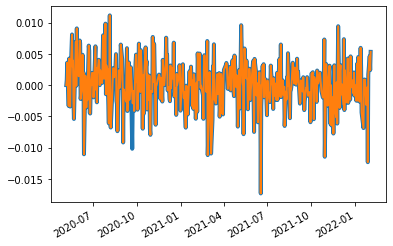

DEXCHUS


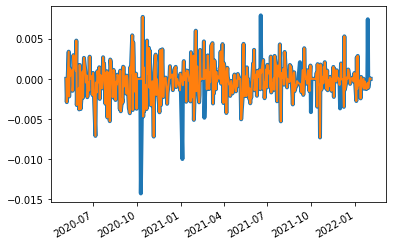

DEXJPUS


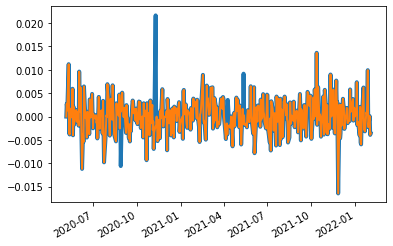

OBMMIJUMBO30YF


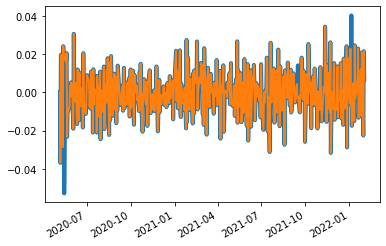

DEXUSUK


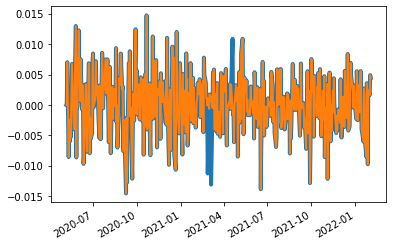

DEXKOUS


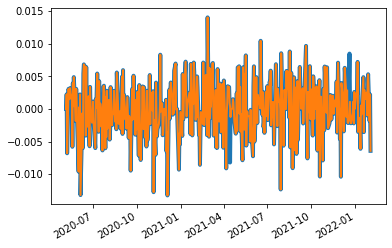

DEXCAUS


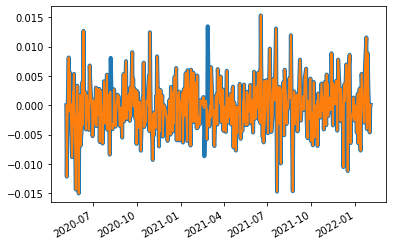

DEXMXUS


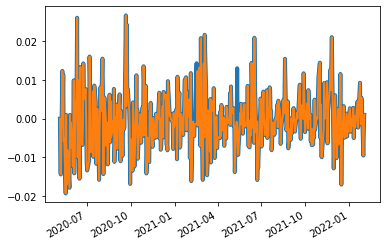

DEXVZUS


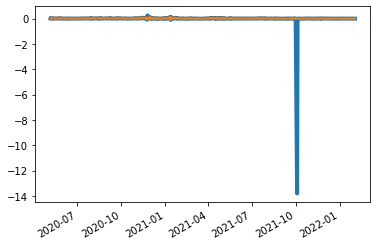

DEXBZUS


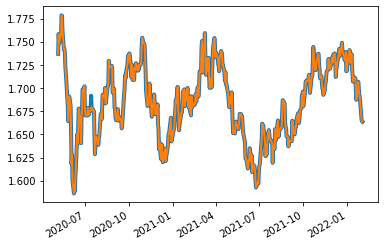

SOFRINDEX


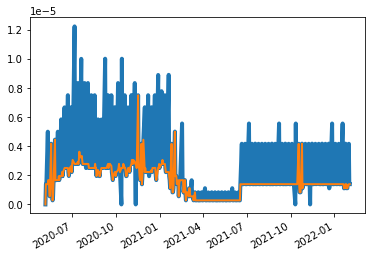

DPROPANEMBTX


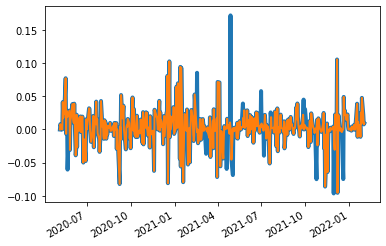

DEXMAUS


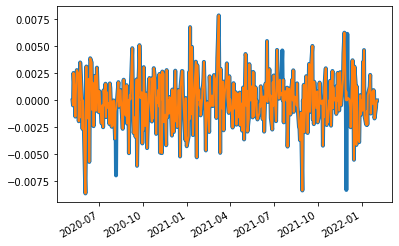

DEXTHUS


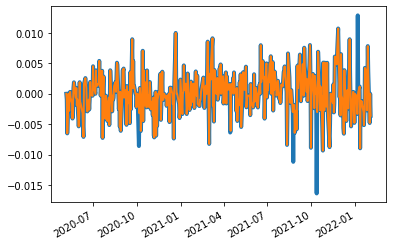

EFFRVOL


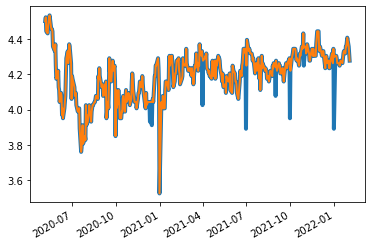

In [77]:
for e in df_copy1:
    ts = hampel(df_copy1[e], n=5, imputation=True)
    print(e)
    df_copy1[e].plot(linewidth=4)
    ts.plot(linewidth=2)
    plt.show()

## 5) Granger Causality Tests

In [78]:
# manual list of companies symbols and names
symbols = ['ADBE', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 
           'ASML', 'TEAM', 'ADSK', 'ADP', 'BIDU', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CHTR', 'CTAS', 
           'CSCO', 'CTSH', 'CMCSA', 'CPRT', 'COST', 'CRWD', 'CSX', 'DXCM', 'DOCU', 'DLTR', 'EBAY', 
           'EA', 'FISV', 'GILD', 'HON', 'IDXX', 'ILMN', 'INTC']
companies = ['Adobe', 'Alphabet A', 'Alphabet C', 'Amazon', 'AMD', 'American Electric Power', 'Amgen',
             'Analog Devices', 'ANSYS', 'Apple', 'Applied Materials', 'ASML', 'Atlassian', 'Autodesk',
             'Automatic Data Processing', 'Baidu.com', 'Biogen', 'Booking Holdings', 'Broadcom',
             'Cadence Design Systems', 'Charte a', 'Cintas', 'Cisco', 'Cognizant', 'Comcast', 'Copart',
             'Costco Wholesale', 'CrowdStrike', 'CSX', 'DexCom', 'DocuSign', 'Dollar Tree', 'eBay',
             'Electronic Arts', 'Fiserv', 'Gilead Sciences', 'Honeywell',
             'IDEXX Laboratories', 'Illumina', 'Intel']

In [ ]:
df_copy1 = (df_copy1-df_copy1.mean())/df_copy1.std()

In [80]:
# initiate a summary table that increments
summary = pd.DataFrame({'lag_selection': ['1', '2', '3']}) # instantiate dataframe
summary.set_index('lag_selection', inplace=True)
for idx, i in enumerate(df_copy1.columns):
    summary[i] = (0,0,0)

In [81]:
# fetch stock symbols data
for idxx, symbol in enumerate(tqdm_notebook(symbols)):
    print(f'\n{symbol}: {companies[idxx]}\n')
    df_temp = pd.DataFrame(pdr.DataReader(f'{symbol}', 'yahoo', '2020-05-06','2022-02-02'))['Adj Close']
    df_temp = 100 * df_temp.pct_change().dropna() # stock returns rather than flat price (stationary attributes)
    df_temp = pd.concat([df_temp, df_copy1], axis=1)
    df_temp = df_temp.dropna(subset=['Adj Close']) # drop only stock price NaNs 
    df_temp = df_temp.interpolate('pad')

    # iterate through all chosen independent variables
    for idx, i in enumerate(df_temp.columns[1:]): # [1:] is because we don't want the added stock return
        print(i)
        lag1 = False
        lag2 = False
        lag3 = False
        gc = grangercausalitytests(df_temp[['Adj Close', i]], 3, verbose=False) # lag = 3, doesnt show output
        
        # get granger causalities p-values
        for e in gc:
            a = gc[e][0].get('ssr_ftest')[1]
            b = gc[e][0].get('ssr_chi2test')[1]
            c = gc[e][0].get('lrtest')[1]
            d = gc[e][0].get('params_ftest')[1]
            p_means = (a+b+c+d)/4
            if e==1 and ((a<0.05) or (b<0.05) or (c<0.05) or (d<0.05)):
                summary[i][0] += 1
                lag1 = True
            if e==2 and ((a<0.05) or (b<0.05) or (c<0.05) or (d<0.05)):
                summary[i][1] += 1
                lag2 = True
            if e==3 and ((a<0.05) or (b<0.05) or (c<0.05) or (d<0.05)): 
                summary[i][2] += 1
                lag3 = True
        if (lag1 + lag2 + lag3) == 3:
            print(f'Granger Causality at lag 1, 2, and 3 between {companies[idxx]} \
stock price and {i} with a p-value of {round(p_means,3)}')
        elif (lag1 + lag2 + lag3) == 2:
            print(f'Granger Causality at lag 2 and 3 between {companies[idxx]} \
stock price and {i} with a p-value of {round(p_means,3)}')
        elif (lag1 + lag2 + lag3) == 1:
            print(f'Granger Causality at lag 3 between {companies[idxx]} \
stock price and {i} with a p-value of {round(p_means,3)}')
clear_output()
print('Summary table is ready')

Summary table is ready


In [82]:
# finally that beautiful summary table
summary.sort_values(by='3', axis=1, ascending=False)

,DEXJPUS,DEXCAUS,DEXBZUS,DEXCHUS,DEXUSEU,DEXKOUS,OBMMIJUMBO30YF,DEXUSUK,DEXVZUS,DEXMAUS,SOFRINDEX,EFFRVOL,DEXMXUS,DPROPANEMBTX,DEXTHUS
lag_selection,,,,,,,,,,,,,,,
1,2,2,6,1,2,2,3,2,0,2,1,0,0,2,0
2,6,4,3,0,3,1,2,2,2,3,1,1,0,0,0
3,7,7,5,4,3,3,2,2,2,2,1,1,0,0,0


In [83]:
summary.sort_values(by='3', axis=1, ascending=False).columns

Index(['DEXJPUS', 'DEXCAUS', 'DEXBZUS', 'DEXCHUS', 'DEXUSEU', 'DEXKOUS',
       'OBMMIJUMBO30YF', 'DEXUSUK', 'DEXVZUS', 'DEXMAUS', 'SOFRINDEX',
       'EFFRVOL', 'DEXMXUS', 'DPROPANEMBTX', 'DEXTHUS'],
      dtype='object')

In [84]:
# let's keep first twenty
final_df = pd.DataFrame()
for e in summary.sort_values(by='3', axis=1, ascending=False).columns:
    final_df[e] = df_copy1[e]

## 6) Variables Behaviors, Outliers

In [85]:
def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False, linewidth=1.5)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False, linewidth=1.5)
    axes[1].set_ylabel('Trend')
    res.resid.plot(ax=axes[2], legend=False, linewidth=1.5)
    axes[2].set_ylabel('Residual')

In [86]:
# convert to proper date format and fill NaNs
final_df = final_df.asfreq('d').interpolate('pad')

DEXJPUS



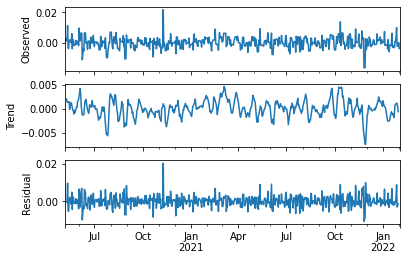

DEXCAUS



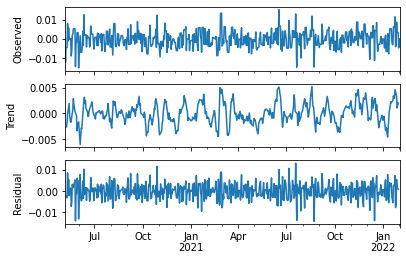

DEXBZUS



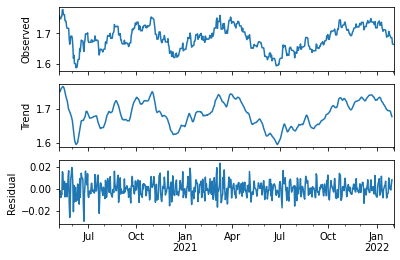

DEXCHUS



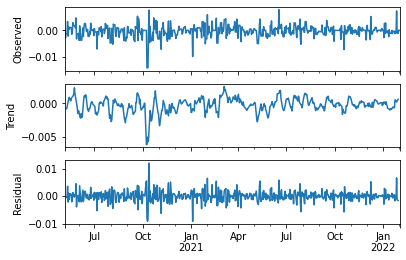

DEXUSEU



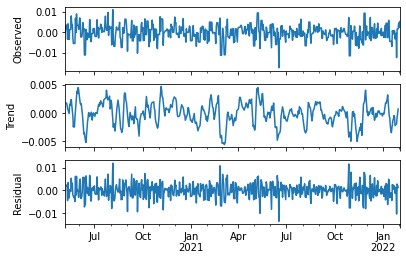

DEXKOUS



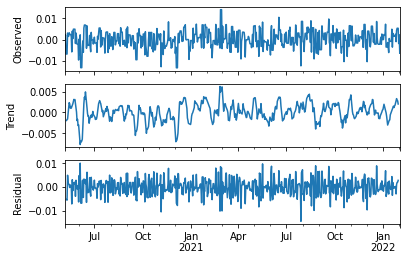

OBMMIJUMBO30YF



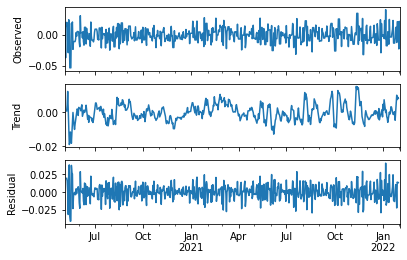

DEXUSUK



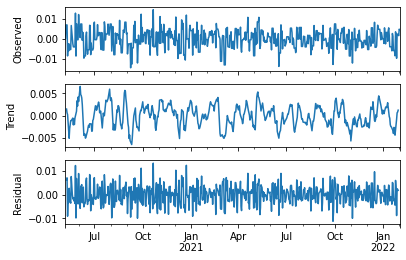

DEXVZUS



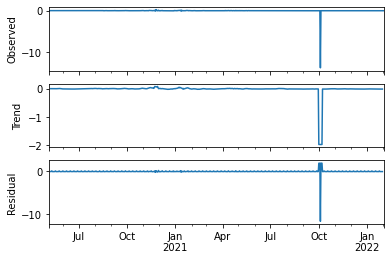

DEXMAUS



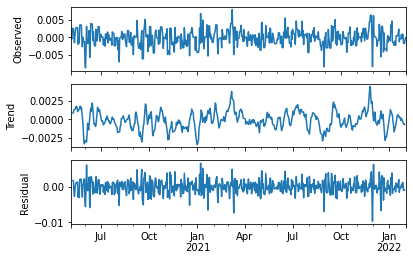

SOFRINDEX



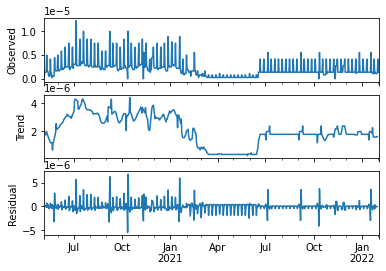

EFFRVOL



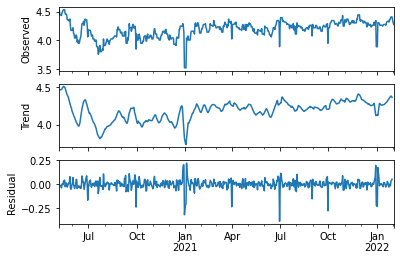

DEXMXUS



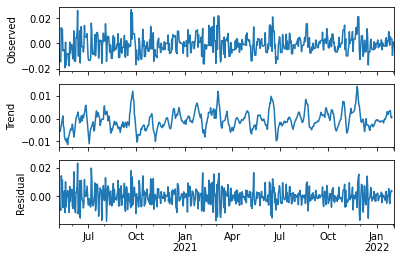

DPROPANEMBTX



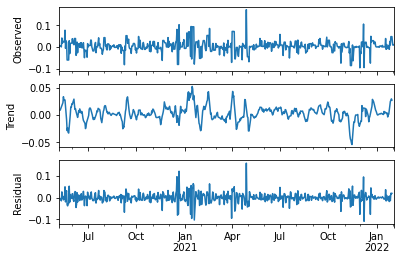

DEXTHUS



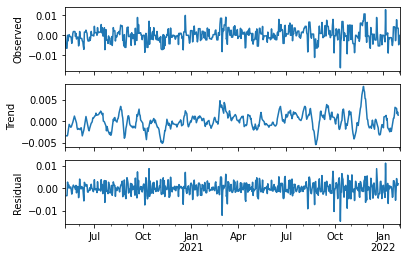

In [87]:
# get time series behaviors, seasonality, detect outliers
for e in final_df:
    print(f'{e}\n')
    res = seasonal_decompose(final_df[e])
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True)
    plotseasonal(res, axes)
    plt.show()

## 7) Check for Gaussian Distribution

In [88]:
for e in final_df:
    stat,p = stats.normaltest(final_df[e])
    print("Statistics = %.3f, p=%.3f" % (stat,p))
    alpha = 0.05
    if p< alpha:
        print('The null hypothesis can be rejected: data is not Gaussian')
    else:
        print('Not enough evidence to reject the null: data looks Gaussian')

Statistics = 62.543, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 11.903, p=0.003
The null hypothesis can be rejected: data is not Gaussian
Statistics = 30.784, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 200.193, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 38.361, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 14.221, p=0.001
The null hypothesis can be rejected: data is not Gaussian
Statistics = 27.348, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 2.681, p=0.262
Not enough evidence to reject the null: data looks Gaussian
Statistics = 1627.416, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 14.869, p=0.001
The null hypothesis can be rejected: data is not Gaussian
Statistics = 303.373, p=0.000
The null hypothesis can be rejected: data is not Gaussian
Statistics = 102.077, p=0.000
The null

## 8) Predicting on 40 stocks

In [97]:
for symbol in tqdm_notebook(symbols):
    stock = pd.DataFrame(pdr.DataReader(f'{symbol}', 'yahoo', '2020-05-06','2022-02-02'))['Adj Close']
    #stock_returns = 100 * stock.pct_change().dropna()
    #df_reg = pd.concat([stock_returns, final_df], axis=1)
    df_reg = pd.concat([stock, final_df], axis=1)
    df_reg = df_reg.dropna(subset=['Adj Close']) # drop only stock price NaNs 
    df_reg.interpolate('pad', inplace=True)
    
    
    X = df_reg.drop(['Adj Close'], axis=1)
    Y = df_reg['Adj Close']
    X_train, Y_train, X_test, Y_test = X[:-5], Y[:-5], X[-5:], Y[-5:]
    model = RandomForestRegressor()
    model.fit(X_train,Y_train) 
    pred = model.predict(X_test)
    Y_test.reset_index(drop=True, inplace=True)
    b = pd.concat([Y_test, pd.DataFrame(pred)], axis=1)
    print(b)
    print(r2_score(Y_test,pred))

  0%|          | 0/40 [00:00<?, ?it/s]

    Adj Close           0
0  493.049988  484.853401
1  518.159973  440.957905
2  534.299988  553.962603
3  535.979980  618.408208
4  533.090027  614.792005
-14.081924385408383
     Adj Close            0
0  2580.100098  2206.501692
1  2667.020020  1875.479602
2  2706.070068  2440.556417
3  2752.879883  2662.989207
4  2960.000000  2712.980723
-10.267700506006452
     Adj Close            0
0  2582.419922  2091.190651
1  2665.790039  1727.531848
2  2713.969971  2481.537295
3  2757.570068  2693.807690
4  2960.729980  2769.865215
-14.207561477010085
     Adj Close            0
0  2792.750000  2786.791772
1  2879.560059  2836.698994
2  2991.469971  3194.216423
3  3023.870117  3413.571797
4  3012.250000  3372.531572
-7.068023474260995
    Adj Close           0
0  102.599998   85.908499
1  105.239998   81.990900
2  114.250000   89.658100
3  116.779999  100.316000
4  122.760002   90.314701
-8.911624352765198
   Adj Close          0
0  88.626923  79.404043
1  89.350601  82.932892
2  89.618271  

KeyboardInterrupt: 